# Setup

In [42]:
import os
from pathlib import Path

# Set working directory to the base directory 'gpudrive'
working_dir = Path.cwd()
while working_dir.name != 'gpudrive-CoDec':
    working_dir = working_dir.parent
    if working_dir == Path.home():
        raise FileNotFoundError("Base directory 'gpudrive' not found")
os.chdir(working_dir)

In [2]:
import torch
import dataclasses
import mediapy
from huggingface_hub import PyTorchModelHubMixin
from huggingface_hub import ModelCard
from gpudrive.networks.late_fusion import NeuralNet

from gpudrive.env.config import EnvConfig
from gpudrive.env.env_torch import GPUDriveTorchEnv, GPUDriveConstrualEnv
from gpudrive.visualize.utils import img_from_fig
from gpudrive.env.dataset import SceneDataLoader
from gpudrive.utils.config import load_config

/home/sbanerjee/PyEnvs/gpuDrive/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


RuntimeError: module compiled against ABI version 0x1000009 but this version of numpy is 0x2000000

RuntimeError: module compiled against ABI version 0x1000009 but this version of numpy is 0x2000000

2025-04-03 19:11:36.890914: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743721896.906794    7452 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743721896.911985    7452 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743721896.924562    7452 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743721896.924588    7452 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743721896.924589    7452 computation_placer.cc:177] computation placer alr

RuntimeError: module compiled against ABI version 0x1000009 but this version of numpy is 0x2000000

### Configs

In [ ]:
# Configs model has been trained with
config = load_config("examples/experimental/config/reliable_agents_params")
print(config)

# datase_path='data/processed/examples'
datase_path='data/processed/training'
# datase_path = 'data/processed/construal'

max_agents = config.max_controlled_agents
num_parallel_envs = 2
total_envs = 1000
device = "cpu" # cpu just because we're in a notebook
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Other changes to variables
config.max_controlled_agents = 1    # Control only the first vehicle in the environment
total_envs = min(total_envs, len(os.listdir(datase_path)))

{'max_controlled_agents': 64, 'ego_state': True, 'road_map_obs': True, 'partner_obs': True, 'norm_obs': True, 'remove_non_vehicles': True, 'lidar_obs': False, 'reward_type': 'weighted_combination', 'collision_weight': -0.75, 'off_road_weight': -0.75, 'goal_achieved_weight': 1.0, 'dynamics_model': 'classic', 'collision_behavior': 'ignore', 'dist_to_goal_threshold': 2.0, 'polyline_reduction_threshold': 0.1, 'sampling_seed': 42, 'obs_radius': 50.0, 'action_space_steer_disc': 13, 'action_space_accel_disc': 7, 'init_mode': 'all_non_trivial', 'vbd_in_obs': False}


### Make environment

In [ ]:
# Create data loader
train_loader = SceneDataLoader(
    root=datase_path,
    batch_size=num_parallel_envs,
    dataset_size=max(total_envs,num_parallel_envs),
    sample_with_replacement=False,
)

# Set params
env_config = dataclasses.replace(
    EnvConfig(),
    ego_state=config.ego_state,
    road_map_obs=config.road_map_obs,
    partner_obs=config.partner_obs,
    reward_type=config.reward_type,
    norm_obs=config.norm_obs,
    dynamics_model=config.dynamics_model,
    collision_behavior=config.collision_behavior,
    dist_to_goal_threshold=config.dist_to_goal_threshold,
    polyline_reduction_threshold=config.polyline_reduction_threshold,
    remove_non_vehicles=config.remove_non_vehicles,
    lidar_obs=config.lidar_obs,
    disable_classic_obs=config.lidar_obs,
    obs_radius=config.obs_radius,
    steer_actions = torch.round(
        torch.linspace(-torch.pi, torch.pi, config.action_space_steer_disc), decimals=3  
    ),
    accel_actions = torch.round(
        torch.linspace(-4.0, 4.0, config.action_space_accel_disc), decimals=3
    ),
)

# |Make env
# env = GPUDriveTorchEnv(
#     config=env_config,
#     data_loader=train_loader,
#     max_cont_agents=config.max_controlled_agents,
#     device=device,
# )

# |Make env
env = GPUDriveConstrualEnv(
    config=env_config,
    data_loader=train_loader,
    max_cont_agents=config.max_controlled_agents,
    device=device,
)


control_mask = env.cont_agent_mask

: 

### Load pre-trained agent via Hugging Face hub


In [4]:
sim_agent = NeuralNet.from_pretrained("daphne-cornelisse/policy_S10_000_02_27")

In [5]:
# Agent has an action dimension of 91: 13 steering wheel angle discretizations x 9 acceleration discretizations
sim_agent.action_dim

91

In [6]:
# Size of flattened observation vector
sim_agent.obs_dim

2984

In [7]:
# Some other info
card = ModelCard.load("daphne-cornelisse/policy_S10_000_02_27")
card.data.tags

['ffn', 'model_hub_mixin', 'pytorch_model_hub_mixin']

In [8]:
# Model architecture
#agent

In [9]:
# Weights 
#agent.state_dict()

In [12]:
env.data_batch

['data/processed/construal/tfrecord-00013-of-01000_447.json',
 'data/processed/construal/tfrecord-00051-of-01000_130.json',
 'data/processed/construal/tfrecord-00290-of-01000_330.json',
 'data/processed/construal/tfrecord-00295-of-01000_114.json',
 'data/processed/construal/tfrecord-00307-of-01000_276.json',
 'data/processed/construal/tfrecord-00320-of-01000_334.json',
 'data/processed/construal/tfrecord-00326-of-01000_255.json',
 'data/processed/construal/tfrecord-00360-of-01000_146.json',
 'data/processed/construal/tfrecord-00434-of-01000_368.json',
 'data/processed/construal/tfrecord-00604-of-01000_9.json',
 'data/processed/construal/tfrecord-00605-of-01000_183.json',
 'data/processed/construal/tfrecord-00624-of-01000_368.json',
 'data/processed/construal/tfrecord-00720-of-01000_131.json',
 'data/processed/construal/tfrecord-00739-of-01000_275.json',
 'data/processed/construal/tfrecord-00762-of-01000_59.json',
 'data/processed/construal/tfrecord-00778-of-01000_343.json',
 'data/proc

# Data Processing

### Inspect JSON structure

In [43]:
import json

In [45]:
# Open and read the JSON file
with open('data/processed/construal/tfrecord-00046-of-01000_167.json', 'r') as file:
    path_1 = json.load(file)

# Open and read the JSON file
with open('data/processed/construal/tfrecord-00495-of-01000_351.json', 'r') as file:
    path_2 = json.load(file)

In [46]:
path_1.keys()

dict_keys(['name', 'scenario_id', 'objects', 'roads', 'tl_states', 'metadata'])

In [47]:
path_1['metadata']

{'sdc_track_index': 64,
 'objects_of_interest': [2217, 251],
 'tracks_to_predict': [{'track_index': 11, 'difficulty': 0},
  {'track_index': 64, 'difficulty': 0},
  {'track_index': 29, 'difficulty': 0},
  {'track_index': 33, 'difficulty': 0},
  {'track_index': 19, 'difficulty': 0}]}

In [12]:
path_1['objects'][0].keys()

dict_keys(['position', 'width', 'length', 'height', 'heading', 'velocity', 'valid', 'goalPosition', 'type', 'id', 'mark_as_expert'])

In [48]:
path_1['objects'][0]

{'position': [{'x': -10000.0, 'y': -10000.0, 'z': -10000.0},
  {'x': -10000.0, 'y': -10000.0, 'z': -10000.0},
  {'x': -10000.0, 'y': -10000.0, 'z': -10000.0},
  {'x': -10000.0, 'y': -10000.0, 'z': -10000.0},
  {'x': -10000.0, 'y': -10000.0, 'z': -10000.0},
  {'x': -10000.0, 'y': -10000.0, 'z': -10000.0},
  {'x': -10000.0, 'y': -10000.0, 'z': -10000.0},
  {'x': -10000.0, 'y': -10000.0, 'z': -10000.0},
  {'x': -10000.0, 'y': -10000.0, 'z': -10000.0},
  {'x': 2373.505615234375, 'y': -2837.07958984375, 'z': 65.5370579606807},
  {'x': 2373.4404296875, 'y': -2837.044677734375, 'z': 65.53267476749299},
  {'x': 2373.46875, 'y': -2836.98974609375, 'z': 65.55056252162947},
  {'x': -10000.0, 'y': -10000.0, 'z': -10000.0},
  {'x': -10000.0, 'y': -10000.0, 'z': -10000.0},
  {'x': -10000.0, 'y': -10000.0, 'z': -10000.0},
  {'x': 2373.395751953125, 'y': -2837.07275390625, 'z': 65.54760728610552},
  {'x': 2373.440673828125, 'y': -2837.04833984375, 'z': 65.55986593833616},
  {'x': 2373.44091796875, 'y'

In [17]:
[obj['mark_as_expert'] for obj in path_1['objects']]

[False,
 False,
 True,
 False,
 True,
 True,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

In [22]:
path_1['objects'][0]['velocity'][40:]

[{'x': 0.0, 'y': 0.0},
 {'x': 0.0, 'y': 0.0},
 {'x': 0.0, 'y': 0.0},
 {'x': 0.0, 'y': 0.0},
 {'x': 0.0, 'y': 0.0},
 {'x': 0.0, 'y': 0.0},
 {'x': 0.0, 'y': 0.0},
 {'x': 0.0, 'y': 0.0},
 {'x': 0.0, 'y': 0.0},
 {'x': -10000.0, 'y': -10000.0},
 {'x': -10000.0, 'y': -10000.0},
 {'x': -10000.0, 'y': -10000.0},
 {'x': -10000.0, 'y': -10000.0},
 {'x': -10000.0, 'y': -10000.0},
 {'x': -10000.0, 'y': -10000.0},
 {'x': -10000.0, 'y': -10000.0},
 {'x': -10000.0, 'y': -10000.0},
 {'x': -10000.0, 'y': -10000.0},
 {'x': -10000.0, 'y': -10000.0},
 {'x': -10000.0, 'y': -10000.0},
 {'x': -10000.0, 'y': -10000.0},
 {'x': -10000.0, 'y': -10000.0},
 {'x': -10000.0, 'y': -10000.0},
 {'x': -10000.0, 'y': -10000.0},
 {'x': -10000.0, 'y': -10000.0},
 {'x': -10000.0, 'y': -10000.0},
 {'x': -10000.0, 'y': -10000.0},
 {'x': -10000.0, 'y': -10000.0},
 {'x': -10000.0, 'y': -10000.0},
 {'x': -10000.0, 'y': -10000.0},
 {'x': -10000.0, 'y': -10000.0},
 {'x': -10000.0, 'y': -10000.0},
 {'x': -10000.0, 'y': -10000.0},
 

In [ ]:
with open('data/processed/construal/tfrecord-00046-of-01000_167.json', 'r') as file:
    curr_data = json.load(file)

veh_obj = curr_data
veh1_pos = [[posdict['x'],posdict['y']] for posdict in veh_obj['position'] if posdict['x']!=-10000]

## Get state-action pairs from trajectory data

In [ ]:
from copy import deepcopy

env1 = deepcopy(env)
env2 = deepcopy(env)
next_obs1 = env1.reset()
next_obs2 = env2.reset() 

control_mask = env.cont_agent_mask

In [ ]:
# For each scenario, get the actions that lead to correct original data states
from copy import deepcopy

env1 = deepcopy(env)
env2 = deepcopy(env)
next_obs1 = env1.reset()
next_obs2 = env2.reset()

control_mask = env.cont_agent_mask

# frames = {f"env_{i}": [] for i in range(num_envs)}

for time_step in range(env.episode_len):
    print(f"\rStep: {time_step}", end="", flush=True)

    # Predict actions
    action, _, _, _ = sim_agent(
        next_obs[control_mask], deterministic=False
    )
    action_template = torch.zeros(
        (total_envs, max_agents), dtype=torch.int64, device=device
    )
    action_template[control_mask] = action.to(device)

    # Step
    env.step_dynamics(action_template)

    # Render    
    sim_states = env.vis.plot_simulator_state(
        env_indices=list(range(total_envs)),
        time_steps=[time_step]*total_envs,
        zoom_radius=70,
    )
    
    for i in range(total_envs):
        frames[f"env_{i}"].append(img_from_fig(sim_states[i])) 

    next_obs = env.get_obs()
    reward = env.get_rewards()
    done = env.get_dones()
    info = env.get_infos()

    if done.all():
        break

env1.close()
env2.close()

# Reference Code

### Construal Simulation

In [ ]:
import math

In [ ]:
construal_size = 5
observed_agents = max_agents - 1    # Agents observed except self (used for vector sizes)
limit_observed_agents = 40          # Maximum nember of agents to observe (used for loop counts)
construal_values = {}               # Dictionary that contains the expected utility per construal
sample_size = 5                     # Number of samples to calculate expected utility of a construal
for const_num in range(math.ceil(limit_observed_agents/construal_size)):
    # Repeat rollout for each construal

    next_obs = env.reset()
    control_mask = env.cont_agent_mask
    # print("Observation shape: ", next_obs.shape)
    frames = {f"env_{i}-constr_{const_num}": [] for i in range(total_envs)}

    ## Define observation mask for construal
    construal_mask = [False]*observed_agents
    mask_start_indx = int(const_num*construal_size)
    mask_end_indx = min(observed_agents, int( ((const_num+1)*construal_size)-1 ))
    # if mask_end_indx >= limit_observed_agents:
    #     break
    print("Construal indices: ", mask_start_indx, "-", mask_end_indx)
    construal_mask[mask_start_indx:mask_end_indx] = [True]*(mask_end_indx-mask_start_indx)
    
    curr_samples = []
    for i in range(sample_size):
        print("\tsample ", i)
        next_obs = env.reset()
        for time_step in range(env.episode_len):
            ## Roll out policy for a specific construal
            print(f"\r\t\tStep: {time_step}", end="", flush=True)

            ### Predict actions
            action, _, _, _ = sim_agent(
                next_obs[control_mask], deterministic=False
            )
            action_template = torch.zeros(
                (total_envs, max_agents), dtype=torch.int64, device=device
            )
            action_template[control_mask] = action.to(device)

            ### Step
            env.step_dynamics(action_template)

            ### Render
            sim_states = env.vis.plot_simulator_state(
                env_indices=list(range(total_envs)),
                time_steps=[time_step]*total_envs,
                zoom_radius=70,
            )
            
            for i in range(total_envs):
                frames[f"env_{i}-constr_{const_num}"].append(img_from_fig(sim_states[i])) 

            # next_obs = env.get_obs(obs_mask)
            next_obs = env.get_obs(partner_mask=construal_mask)
            reward = env.get_rewards()
            done = env.get_dones()
            info = env.get_infos()
            
            if done.all():
                break
        print() # Change to new line after step prints
            
        curr_samples.append(reward[control_mask].tolist())
    construal_values[(mask_start_indx,mask_end_indx)] = [sum(x)/sample_size for x in zip(*curr_samples)]

    ## Save animations
    # mediapy.set_show_save_dir('./sim_vids')
    # mediapy.show_videos(frames, fps=15, width=500, height=500, columns=2, codec='gif')

# env.close()
print("\nExpected utility by contrual: ", construal_values)

Construal indices:  0 - 5
	sample  0
		Step: 0

		Step: 90
	sample  1
		Step: 90
	sample  2
		Step: 90
	sample  3
		Step: 90
	sample  4
		Step: 90
Construal indices:  5 - 10
	sample  0
		Step: 90
	sample  1
		Step: 90
	sample  2
		Step: 90
	sample  3
		Step: 90
	sample  4
		Step: 90
Construal indices:  10 - 15
	sample  0
		Step: 90
	sample  1
		Step: 90
	sample  2
		Step: 90
	sample  3
		Step: 90
	sample  4
		Step: 90
Construal indices:  15 - 20
	sample  0
		Step: 90
	sample  1
		Step: 90
	sample  2
		Step: 90
	sample  3
		Step: 90
	sample  4
		Step: 90
Construal indices:  20 - 25
	sample  0
		Step: 90
	sample  1
		Step: 90
	sample  2
		Step: 90
	sample  3
		Step: 90
	sample  4
		Step: 90
Construal indices:  25 - 30
	sample  0
		Step: 90
	sample  1
		Step: 90
	sample  2
		Step: 90
	sample  3
		Step: 90
	sample  4
		Step: 90
Construal indices:  30 - 35
	sample  0
		Step: 90
	sample  1
		Step: 90
	sample  2
		Step: 90
	sample  3
		Step: 90
	sample  4
		Step: 90
Construal indices:  35 - 40
	sample  0
		Step: 90
	sample  1
		Step: 90
	s

In [ ]:
# Run the simulation with only 1 observed car

import math

construal_size = 1
observed_agents = max_agents - 1    # Agents observed except self (used for vector sizes)
limit_observed_agents = 40          # Maximum nember of agents to observe (used for loop counts)
construal_values = {}               # Dictionary that contains the expected utility per construal
sample_size = 5                     # Number of samples to calculate expected utility of a construal
for const_num in range(math.ceil(limit_observed_agents/construal_size)):
    # Repeat rollout for each construal size

    next_obs = env.reset()
    control_mask = env.cont_agent_mask
    # print("Observation shape: ", next_obs.shape)
    frames = {f"env_{i}-constr_{const_num}": [] for i in range(total_envs)}

    ## Define observation mask for construal
    construal_mask = [False]*observed_agents
    mask_start_indx = int(const_num*construal_size)
    mask_end_indx = min(observed_agents, int((const_num+1)*construal_size))
    # if mask_end_indx >= limit_observed_agents:
    #     break
    print("Construal indices: ", mask_start_indx, "-", mask_end_indx)
    construal_mask[mask_start_indx:mask_end_indx] = [True]*(mask_end_indx-mask_start_indx)
    
    curr_samples = []
    for i in range(sample_size):
        print("\tsample ", i)
        next_obs = env.reset()
        for time_step in range(env.episode_len):
            ## Roll out policy for a specific construal
            print(f"\r\t\tStep: {time_step}", end="", flush=True)

            ### Predict actions
            action, _, _, _ = sim_agent(
                next_obs[control_mask], deterministic=False
            )
            action_template = torch.zeros(
                (total_envs, max_agents), dtype=torch.int64, device=device
            )
            action_template[control_mask] = action.to(device)

            ### Step
            env.step_dynamics(action_template)

            ### Render
            sim_states = env.vis.plot_simulator_state(
                env_indices=list(range(total_envs)),
                time_steps=[time_step]*total_envs,
                zoom_radius=70,
            )
            
            for i in range(total_envs):
                frames[f"env_{i}-constr_{const_num}"].append(img_from_fig(sim_states[i])) 

            # next_obs = env.get_obs(obs_mask)
            next_obs = env.get_obs(partner_mask=construal_mask)
            reward = env.get_rewards()
            done = env.get_dones()
            info = env.get_infos()
            
            if done.all():
                break
        print() # Change to new line after step prints
            
        curr_samples.append(reward[control_mask].tolist())
    construal_values[(mask_start_indx,mask_end_indx)] = [sum(x)/sample_size for x in zip(*curr_samples)]
    break
    ## Save animations
    # mediapy.set_show_save_dir('./sim_vids')
    # mediapy.show_videos(frames, fps=15, width=500, height=500, columns=2, codec='gif')

# env.close()
print("\nExpected utility by contrual: ", construal_values)

Construal indices:  0 - 1
	sample  0
		Step: 85
	sample  1
		Step: 85
	sample  2
		Step: 85
	sample  3
		Step: 85
	sample  4
		Step: 85

Expected utility by contrual:  {(0, 1): [1.0, 1.0]}


### Original Rollout

In [ ]:
next_obs = env.reset()

control_mask = env.cont_agent_mask

print(next_obs.shape)

frames = {f"env_{i}": [] for i in range(total_envs)}

for time_step in range(env.episode_len):
    print(f"\rStep: {time_step}", end="", flush=True)

    # Predict actions
    action, _, _, _ = sim_agent(
        next_obs[control_mask], deterministic=False
    )
    action_template = torch.zeros(
        (total_envs, max_agents), dtype=torch.int64, device=device
    )
    action_template[control_mask] = action.to(device)

    # Step
    env.step_dynamics(action_template)

    # Render    
    sim_states = env.vis.plot_simulator_state(
        env_indices=list(range(total_envs)),
        time_steps=[time_step]*total_envs,
        zoom_radius=70,
    )
    
    for i in range(total_envs):
        frames[f"env_{i}"].append(img_from_fig(sim_states[i])) 

    next_obs = env.get_obs()
    reward = env.get_rewards()
    done = env.get_dones()
    info = env.get_infos()

    if done.all():
        break

# env.close()

torch.Size([4, 64, 2984])
Step: 6

KeyboardInterrupt: 

env_0,env_1
env_2,env_3

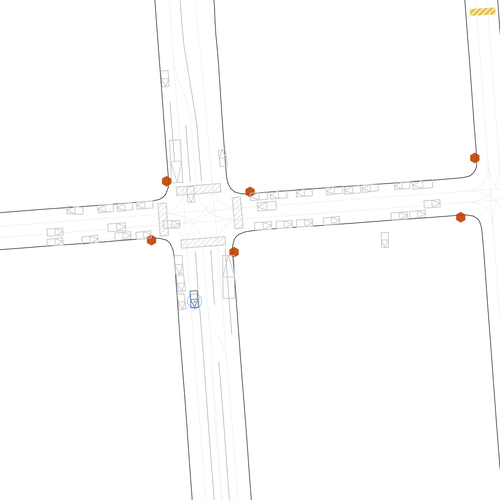
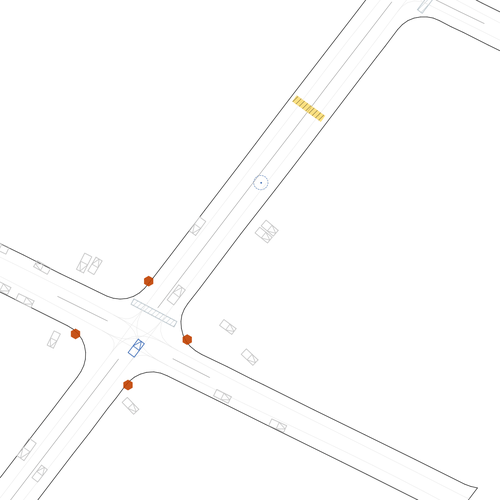
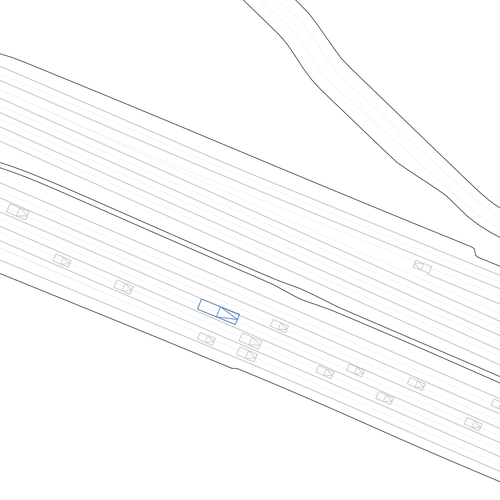
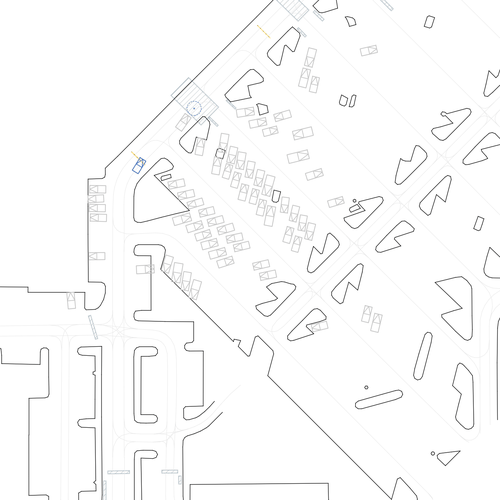

In [15]:
mediapy.set_show_save_dir('./sim_vids')
mediapy.show_videos(frames, fps=15, width=500, height=500, columns=2, codec='gif')

### Use the agent

In [12]:
next_obs = env.reset()

control_mask = env.cont_agent_mask

next_obs.shape

torch.Size([2, 64, 2984])

In [13]:
action, logprob, entropy, value = sim_agent(
    next_obs[control_mask], deterministic=False
)

In [14]:
action.shape, logprob.shape, entropy.shape, value.shape

(torch.Size([2]), torch.Size([2]), torch.Size([2]), torch.Size([2, 1]))

In [ ]:
curr_veh = control_mask.nonzero()[4]
control_mask[curr_veh[0], curr_veh[1]]
curr_veh